In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from IPython.display import clear_output
from torch.distributions import Categorical




class TBModel(nn.Module):
    def __init__(self,action_space, hidden_dim=256, lr=3e-4):
        super().__init__()
        # include the stop bit
        self.action_space = action_space + 1

        self.mlp = nn.Sequential(
            nn.Linear(self.action_space, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, (self.action_space * 2))
        )
        self.optimizer=torch.optim.Adam(self.parameters(),  lr)
        self.logZ = nn.Parameter(torch.ones(1))
    def forward(self, x):
        logits = self.mlp(x)
        A = self.action_space
        # first A entries for P_F
        P_F = logits[..., :A] * (1 - x) + x * -100
        # next A entries for P_B
        P_B = logits[..., A:] * x + (1 - x) * -100
        # final 1 for flow
        #flow = logits[..., 2*A:]
        return P_F, P_B#, flow

def reward_fn_batch(states, synergy_sets, overrides=None, noise_std=0.01):
    """
    Batch version matching reward_fn_single exactly.

    Args:
      states:       Tensor[B, D], binary {0,1}
      synergy_sets: List of lists of feature‐indices, e.g. [[0,1,2], …]
      overrides:    Dict[ tuple(S) -> { pattern_tuple -> multiplier } ]
      noise_std:    float

    Returns:
      rewards: Tensor[B]
    """
    B, D = states.shape
    device = states.device

    # 1) Base reward (sum of bits)
    base = states.sum(dim=1).float()              # [B]

    # 2) For each synergy‐set compute its score per sample
    if overrides is None:
        overrides = {}
    if not synergy_sets:
        # no synergy sets → no bonus
        synergy_reward = torch.zeros(B, device=device)
    else:
        all_scores = []
        for S in synergy_sets:
            S_tuple = tuple(S)
            idx = torch.tensor(S, device=device)
            subset = states[:, idx]               # [B, |S|]

            # (sum / |S|) * D
            sums = subset.sum(dim=1).float()      # [B]
            score = sums.div(len(S)).mul(D)       # [B]

            # apply per-pattern overrides
            if S_tuple in overrides:
                ov = overrides[S_tuple]           # dict mapping pattern->multiplier
                # build list of patterns for each sample
                # e.g. patterns[i] = (0,1,1,0)
                patterns = [tuple(s.tolist()) for s in subset]
                # apply multipliers
                for pattern, mult in ov.items():
                    mask = torch.tensor(
                        [p == pattern for p in patterns],
                        dtype=torch.bool, device=device
                    )
                    # only on those samples whose pattern matches
                    score = torch.where(mask, score * mult, score)

            all_scores.append(score)              # list of [B]

        # stack → [B, num_sets]
        synergy_scores = torch.stack(all_scores, dim=1)

        # sum of negative scores per sample
        sum_negative = synergy_scores.clamp_max(0).sum(dim=1)  # [B]
        # max positive per sample
        max_positive, _ = synergy_scores.max(dim=1)           # [B]

        # if any positive, bonus = max_positive + sum_negative, else = sum_negative
        synergy_reward = torch.where(
            max_positive > 0,
            max_positive + sum_negative,
            sum_negative
        )                                                      # [B]

    # 3) final reward: if synergy_reward<0 → that; else = (max(base, synergy_reward) - base)
    reward = torch.where(
        synergy_reward < 0,
        synergy_reward,
        torch.max(base, synergy_reward) - base
    )

    # 4) add noise
    if noise_std > 0.0:
        noise = torch.randn(B, device=device) * noise_std
        reward = reward + noise

    return reward


def reward_fn_batch_avg(states, synergy_sets, overrides=None, noise_std=0.01, k=10):
    """
    Runs `reward_fn_batch` `k` times on the same inputs and returns the per-sample average reward.

    Args:
      states:       Tensor[B, D], binary {0,1}
      synergy_sets: List of lists of feature‐indices
      overrides:    Optional dict of per‐pattern multipliers
      noise_std:    float, passed through to reward_fn_batch
      k:            int, number of repetitions

    Returns:
      avg_rewards: Tensor[B]
    """
    B = states.size(0)
    device = states.device
    total = torch.zeros(B, device=device)
    for _ in range(k):
        total += reward_fn_batch(states, synergy_sets, overrides=overrides, noise_std=noise_std)
    return total.div(k)


In [8]:

class gflownet:
    def __init__(
        self,
        model,
        reward_fn,
        device='cpu',
        action_space=500,
        max_steps=7,
        min_steps=2,
        initial_temp=10.0,
        final_temp=1.0,
        total_episodes=20_000,
        batch_size=100,
        decay_fraction=0.1,
        verbose=False
    ):
        """
        model        : your torch.nn.Module (must have .logZ attribute)
        optimizer    : optimizer for the model
        reward_fn    : function(batch_states) -> rewards
        device       : 'cpu' or torch.device
        action_space : int
        max_steps    : int
        min_steps    : int
        initial_temp : float, starting temperature
        final_temp   : float, ending temperature
        total_episodes: int, total number of rollouts
        batch_size   : int
        decay_fraction: float, fraction of total batches over which to decay temp
        """
        self.model          = model.to(device)
        self.optimizer      = model.optimizer
        self.reward_fn      = reward_fn
        self.device         = device
        self.action_space   = action_space
        self.max_steps      = max_steps
        self.min_steps      = min_steps
        self.initial_temp   = initial_temp
        self.final_temp     = final_temp
        self.total_episodes = total_episodes
        self.batch_size     = batch_size
        self.verbose        = verbose
        # how many batches to decay over
        self.decay_batches  = (self.total_episodes / self.batch_size) * decay_fraction

    def cosine_similarity_matrix(self,final_states):
        """
        Computes a matrix of pairwise cosine similarities for a batch of state vectors.
        values are fixed between 0 and 1 because of my inputs being fixed as 0 or 1
        
        Args:
            final_states: Tensor of shape (batch_size, state_dim)
        
        Returns:
            A tensor of shape (batch_size, batch_size) containing pairwise cosine similarities.
        """
        # Normalize the states along the feature dimension
        normalized_states = F.normalize(final_states, dim=1)
        # Compute cosine similarity as the dot product of normalized vectors
        sim_matrix = torch.matmul(normalized_states, normalized_states.transpose(0, 1))
        return sim_matrix
    
    def diversity_loss(self,final_states, weight=1.0):
        """
        Computes a diversity loss that penalizes pairwise similarity among final states.
        
        Args:
            final_states: Tensor of shape (batch_size, state_dim)
            weight: A scaling factor for the loss
        
        Returns:
            A scalar diversity loss.
        """
        sim_matrix = self.cosine_similarity_matrix(final_states)
        batch_size = sim_matrix.shape[0]
        # Exclude the diagonal (each state compared with itself)
        mask = torch.ones_like(sim_matrix) - torch.eye(batch_size, device=sim_matrix.device)
        pairwise_sim = sim_matrix * mask
        # Sum up the similarities; higher sum means less diversity.
        loss = weight * pairwise_sim.sum() / (batch_size * (batch_size - 1))
        return loss
    def compute_temperature(self, batch_idx):
        frac = batch_idx / self.decay_batches
        return max(
            self.final_temp,
            self.initial_temp - (self.initial_temp - self.final_temp) * frac
        )

    
    def forward_rollout_batch(self,temp):
        """
        Same functionality; fused masks, single idx tensor, inline backward,
        clones preserved for autograd.
        """
        A            = self.model.action_space
        stop_idx     = A - 1
        action_value = 1.0
    
        # Initialize
        state       = torch.zeros(self.batch_size, A, device=device)
        log_P_F     = torch.zeros(self.batch_size, device=device)
        log_P_B     = torch.zeros(self.batch_size, device=device)
        finished    = torch.zeros(self.batch_size, dtype=torch.bool, device=device)
        reward      = torch.zeros(self.batch_size, device=device)
        steps       = torch.zeros(self.batch_size, dtype=torch.int32, device=device)
    
        idx = torch.arange(A, device=device)
    
        for t in range(self.max_steps):
            alive = torch.nonzero(~finished, as_tuple=True)[0]
            if alive.numel() == 0:
                break
    
            s = state[alive]                     # [B_alive, A]
            logits, _ = self.model(s)                 # [B_alive, A]
    
            # build & apply fused mask
            m = s.eq(action_value)
            fill = float('-1e8')
            if t < self.min_steps:
                m |= idx.eq(stop_idx)
            elif t == self.max_steps - 1:
                m |= idx.ne(stop_idx)
                fill = float('-1e9')
    
            logits = logits.masked_fill(m, fill) / temp
    
            # sample forward
            cat = Categorical(logits=logits)
            acts = cat.sample()                  # [B_alive]
            log_P_F[alive]     += cat.log_prob(acts)
    
            # update state (clone)
            new_s = s.clone()
            new_s[torch.arange(len(acts), device=self.device), acts] = action_value
            state[alive] = new_s
    
            # inline backward log-prob
            log_P_B[alive] += Categorical(logits=self.model(new_s)[1]).log_prob(acts)
    
            # record stops
            stops = acts == stop_idx
            if stops.any():
                idxs = alive[stops]
                reward[idxs]   = reward_fn(new_s[stops, :-1]).clamp(min=0).float()
                steps[idxs]    = t + 1
                finished[idxs] = True
    
        # finalize any trajectories that never stopped
        never = ~finished
        if never.any():
            steps[never]  = max_steps
            reward[never] = self.reward_fn(state[never, :-1]).clamp(min=0).float()
        return state, log_P_B, log_P_F, reward
        

    
    def rollout_and_compute_loss(self, temp):
        """
        Performs one rollout and returns:
          - final states tensor
          - average reward (float)
          - combined loss tensor (TB + entropy + optional diversity)
        """
        state, log_P_B, log_P_F, rewards= self.forward_rollout_batch(temp=temp)

        # === 2) TB loss ===
        # TB term: (logZ + forward_logp - log(reward) - backward_logp)^2
        tb_term = self.model.logZ + log_P_F - torch.log(rewards.clamp_min(1e-8)) - log_P_B
        tb_loss = tb_term.pow(2).sum()


        return state, rewards.mean().item(), tb_loss

    def train(self):
        n_batches = int(self.total_episodes / self.batch_size)
        print("Starting training…")
        for batch_idx in range(n_batches):
            # 1) temperature
            temp = self.compute_temperature(batch_idx)

            # 2) rollout + basic loss
            final_states, mean_reward, loss = self.rollout_and_compute_loss(temp)

            # 3) diversity penalty (skip on first batch)
            if batch_idx > 0:
                div_pen = self.diversity_loss(final_states[:, :-1], weight=1.0)
                loss = loss + div_pen
            else:
                div_pen = 0.0

            # 4) backward & step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # 5) logging
            if (batch_idx % 10 == 0) and (batch_idx > 0) and self.verbose:
                clear_output(wait=True)
                print(
                    f"[Batch {batch_idx:4d}/{n_batches:4d}] "
                    f"Loss: {loss.item():.4f} | "
                    f"Reward: {mean_reward:.2f} | "
                    f"Diversity Penalty: {div_pen:.4f}"
                )

        print("Training complete.")

    def generate(self,batch_size):
        """
        Same functionality; fused masks, single idx tensor, inline backward,
        clones preserved for autograd.
        """
        self.model.eval()
        A            = self.model.action_space
        stop_idx     = A - 1
        action_value = 1.0
        temp=1.0
        # Initialize
        state       = torch.zeros(batch_size, A, device=device)
        finished    = torch.zeros(batch_size, dtype=torch.bool, device=device)
        reward      = torch.zeros(batch_size, device=device)
        steps       = torch.zeros(batch_size, dtype=torch.int32, device=device)
    
        idx = torch.arange(A, device=device)
    
        for t in range(self.max_steps):
            alive = torch.nonzero(~finished, as_tuple=True)[0]
            if alive.numel() == 0:
                break
    
            s = state[alive]                     # [B_alive, A]
            logits, _ = self.model(s)                 # [B_alive, A]
    
            # build & apply fused mask
            m = s.eq(action_value)
            fill = float('-1e8')
            if t < self.min_steps:
                m |= idx.eq(stop_idx)
            elif t == self.max_steps - 1:
                m |= idx.ne(stop_idx)
                fill = float('-1e9')
    
            logits = logits.masked_fill(m, fill) / temp
    
            # sample forward
            cat = Categorical(logits=logits)
            acts = cat.sample()                  # [B_alive]
    
            # update state (clone)
            new_s = s.clone()
            new_s[torch.arange(len(acts), device=self.device), acts] = action_value
            state[alive] = new_s
    
    
            # record stops
            stops = acts == stop_idx
            if stops.any():
                idxs = alive[stops]
                reward[idxs]   = reward_fn(new_s[stops, :-1]).clamp(min=0).float()
                steps[idxs]    = t + 1
                finished[idxs] = True
    
        # finalize any trajectories that never stopped
        never = ~finished
        if never.any():
            steps[never]  = max_steps
            reward[never] = self.reward_fn(state[never, :-1]).clamp(min=0).float()
        self.model.train()
        return state, reward
    

    def estimate_bit_frequencies(self,samples):
        """
        Estimate the frequency of each bit being 1 across a set of samples.
        
        Args:
            samples (Tensor): A binary tensor of shape (num_samples, n), where each row is a candidate vector.
        
        Returns:
            Tensor: A tensor of shape (n,) where each element is the fraction of samples with that bit set to 1.
        """
        samples_float = samples.float()
        frequencies = samples_float.mean(dim=0)
        return frequencies   


In [11]:

import os
import pickle

main_path="/home/jislam/Documents/gits/gflownet/"
results_directory="custom_environment_gflownet_implementation/"
results_file="simulation.pkl"
outdir=main_path+results_directory
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Set up the parameters you want to “bake in”
noise_sds     = [1.0,5.0,10.0]
replications  = 100

synergy_sets = [[0,1,2,3,4,5,6,7,8,9], [12,13,14]]
overrides    = {(12,13,14): {(1,0,1): 0.1}}

action_space  = 500
hidden_dim    = 256
experts       = 4
max_steps     = 5
min_steps     = 2
initial_temp  = 10.0
final_temp    = 1.0
total_episodes= 20000
batch_size    = 100
decay_fraction= 0.1      # decay over 1/10 of batches


device="cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_samples=5000
baseline_results={}
moe_results={}



if os.path.exists(outdir+results_file):
    with open(outdir+results_file, 'rb') as f:
        saved_results = pickle.load(f)
        baseline_results = saved_results.get('baseline_results', {})
        moe_results = saved_results.get('moe_results', {})
    print(f"Loaded existing results from '{results_file}'.")
else:
    baseline_results = {}
    moe_results = {}


for noise_std in noise_sds:
    # Create a single callable that already has these parameters bound
    reward_fn = partial(
        reward_fn_batch_avg,
        noise_std   = noise_std,
        synergy_sets= synergy_sets,
        overrides   = overrides,
        k           = 20
    )

    for i in range(replications):
        clear_output(wait=True)
        print(f'noise: {noise_std}|replication: {i}')
        torch.cuda.empty_cache()
        # Create a unique key for this noise_std and replication iteration.
        key = f'sd_{noise_std}...iter:{i}'
        
        # Check whether this iteration's results already exist.
        if key in baseline_results or key in moe_results:
            print(f"Result for {key} already exists. Skipping...")
            continue


        

        

        model     = TBModel( action_space=action_space, hidden_dim=hidden_dim*(experts+1))
        
        
        gfn_baseline = gflownet(
            model         = model,
            reward_fn     = reward_fn,
            device        = device,
            action_space  = action_space,
            max_steps     = max_steps,
            min_steps     = min_steps,
            initial_temp  = initial_temp,
            final_temp    = final_temp,
            total_episodes= total_episodes,
            batch_size    = batch_size,
            decay_fraction= decay_fraction,
            verbose=False
        )
        gfn_baseline.train()
        
        tb_sampled,sampled_rewards=gfn_baseline.generate(batch_size=num_samples)
        
        bit_frequencies_baseline = gfn_baseline.estimate_bit_frequencies(tb_sampled)
        
        
        # Save the results in the dictionaries. Note that we call .clone().detach().cpu() for safety.
        baseline_results[key] = {bit_frequencies_baseline.clone().detach().cpu()}

        
# Save both baseline_results and moe_results into a single pickle file.
all_results = {'baseline_results': baseline_results, 'moe_results': moe_results}
with open(outdir+results_file, 'wb') as f:
    pickle.dump(all_results, f)

print(f"Results have been saved to '{results_file}'.")

noise: 10.0|replication: 99
Starting training…
Training complete.
Results have been saved to 'simulation.pkl'.


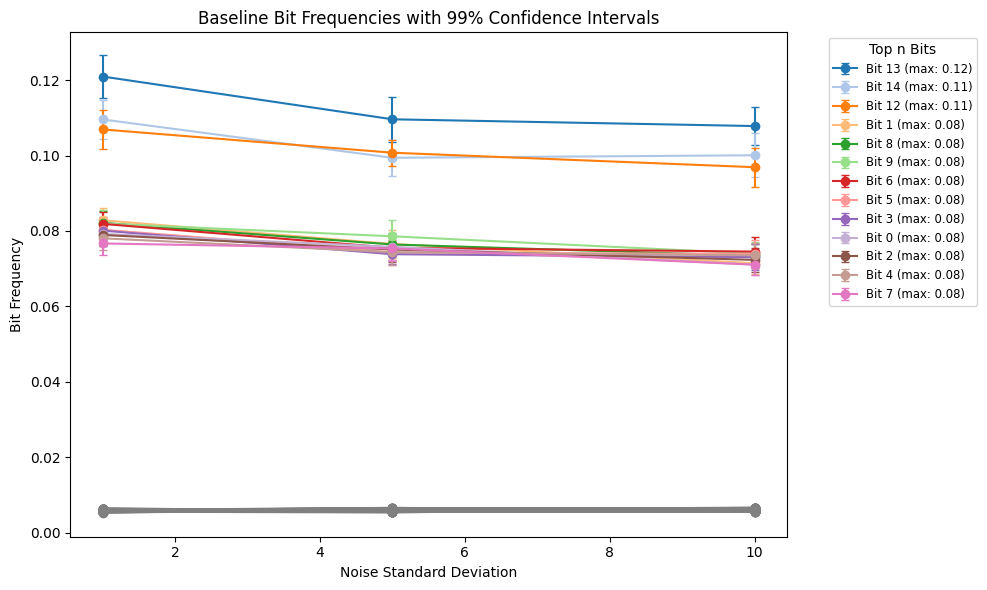

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# Example dictionary structures for baseline_results and moe_results:
# They are assumed to be of the form:
# baseline_results['sd_{noise:.2f}...iter:{i}'] = {bit_frequencies_tensor}
# where bit_frequencies_tensor is a 1D tensor of length (action_space+1).

def group_results(results_dict):
    """
    Groups the stored results by noise standard deviation.

    Args:
        results_dict (dict): Dictionary with keys like "sd_0.00...iter:0" and values
                             that are a set containing the bit frequency tensor.
    
    Returns:
        grouped (dict): A dictionary mapping noise standard deviation (float)
                        to a tensor of shape (replications, num_bits).
    """
    grouped = {}
    for key, value in results_dict.items():
        # Extract noise standard deviation from key (expected format: 'sd_{noise:.2f}...iter:{i}')
        noise_str = key.split('...')[0]  # e.g., "sd_0.00"
        noise_val = float(noise_str.split('_')[1])
        if noise_val not in grouped:
            grouped[noise_val] = []
        # Extract the tensor from the set (each value is stored as a set with one tensor)
        tensor_val = list(value)[0] if isinstance(value, set) else value
        grouped[noise_val].append(tensor_val[:-1])
    
    # Stack the tensors for each noise standard deviation into one tensor:
    # resulting shape: (replications, num_bits) for each noise level.
    for noise in grouped:
        grouped[noise] = torch.stack(grouped[noise], dim=0)
    return grouped



def plot_bit_frequencies(grouped_data, title):
    """
    Creates a plot of bit frequency means with 95% confidence intervals.
    
    Args:
        grouped_data (dict): Dictionary mapping noise values to tensors of shape (replications, num_bits).
        title (str): Title of the figure.
    """
    plt.figure(figsize=(10, 6))
    
    # For each bit position, compute the mean and confidence interval across noise levels.
    for bit in range(num_bits):
        means = []
        cis = []
        for noise in noise_levels:
            # Get the data for a given noise level.
            data = grouped_data[noise].numpy()  # shape: (replications, num_bits)
            bit_data = data[:, bit]             # values for this bit across replications
            mean = np.mean(bit_data)
            std  = np.std(bit_data, ddof=1)       # use ddof=1 for an unbiased estimate
            sem  = std / np.sqrt(replications)    # standard error of the mean
            ci   = t_val * sem                    # confidence interval
            
            means.append(mean)
            cis.append(ci)
        # Plot error bars for this bit position.
        plt.errorbar(noise_levels, means, yerr=cis, marker='o', capsize=3, label=f'Bit {bit}')
    
    plt.xlabel('Noise Standard Deviation')
    plt.ylabel('Bit Frequency')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

def plot_bit_frequencies_topn(grouped_data, title, top_n=3):
    """
    Plots the bit frequency curves with error bars representing 95% confidence intervals.
    Only the top_n bits—based on their highest mean frequency over the x-axis—are given
    unique colors and included in the legend. All other bits are drawn in gray.

    Args:
        grouped_data (dict): Maps noise values to tensors of shape (replications, num_bits).
        title (str): The title of the plot.
        top_n (int): The number of top-scoring bits (by max mean value) to highlight.
    """
    # Get a sorted list of noise levels.
    noise_levels = sorted(grouped_data.keys())
    replications = grouped_data[noise_levels[0]].shape[0]
    num_bits = grouped_data[noise_levels[0]].shape[1]

    # Calculate the t multiplier for 95% confidence intervals.
    confidence = 0.95
    t_val = t.ppf((1 + confidence) / 2, replications - 1)

    # Create a dictionary to store means, CIs, and the max score for each bit.
    bit_values = {}
    for bit in range(num_bits):
        means = []
        cis = []
        for noise in noise_levels:
            data = grouped_data[noise].numpy()  # shape: (replications, num_bits)
            bit_data = data[:, bit]
            mean_val = np.mean(bit_data)
            std_val = np.std(bit_data, ddof=1)
            sem = std_val / np.sqrt(replications)
            ci = t_val * sem
            means.append(mean_val)
            cis.append(ci)
        # Compute a "score" as the maximum mean frequency across the x-axis values.
        max_mean = max(means)
        bit_values[bit] = {
            'means': means,
            'cis': cis,
            'max_mean': max_mean
        }
    
    # Determine which bit indices are in the top_n (sorted by their highest scores).
    sorted_bits = sorted(bit_values.keys(), key=lambda b: bit_values[b]['max_mean'], reverse=True)
    top_n_bits = sorted_bits[:top_n]

    # Assign unique colors to each of the top_n bits using a colormap.
    cmap = plt.get_cmap('tab20')
    top_colors = {bit: cmap(i) for i, bit in enumerate(top_n_bits)}

    plt.figure(figsize=(10, 6))

    # Plot the top_n bits with unique colors and add legend labels.
    for bit in top_n_bits:
        plt.errorbar(noise_levels,
                     bit_values[bit]['means'],
                     yerr=bit_values[bit]['cis'],
                     marker='o',
                     capsize=3,
                     label=f'Bit {bit} (max: {bit_values[bit]["max_mean"]:.2f})',
                     color=top_colors[bit])
    
    # Plot the remaining bits in gray (no legend label).
    remaining_bits = set(bit_values.keys()) - set(top_n_bits)
    for bit in remaining_bits:
        plt.errorbar(noise_levels,
                     bit_values[bit]['means'],
                     yerr=bit_values[bit]['cis'],
                     marker='o',
                     capsize=3,
                     color='gray')

    plt.xlabel('Noise Standard Deviation')
    plt.ylabel('Bit Frequency')
    plt.title(title)
    plt.legend(title='Top n Bits', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.savefig('simple_gfn_simulation.png')
    plt.show()




# Group the results
baseline_grouped = group_results(baseline_results)

# Get sorted list of noise values and determine number of bits from one sample.
noise_levels = sorted(baseline_grouped.keys())
num_bits = baseline_grouped[noise_levels[0]].shape[1]
replications = baseline_grouped[noise_levels[0]].shape[0]

# For a 95% confidence interval, compute the t multiplier given replications
confidence = 0.99
t_val = t.ppf((1 + confidence) / 2, replications - 1)


# Example usage:
# Assume baseline_grouped and moe_grouped have been generated as in the previous code.
plot_bit_frequencies_topn(baseline_grouped, 'Baseline Bit Frequencies with 99% Confidence Intervals', top_n=13)
